In [1]:
import QUANTAXIS as QA
try:
    assert QA.__version__=='1.0.36'
except AssertionError:
    print('pip install QUANTAXIS == 1.0.36 请升级QUANTAXIS后再运行此示例')

QUANTAXIS>> start QUANTAXIS
QUANTAXIS>> Welcome to QUANTAXIS, the Version is 1.0.36
QUANTAXIS>>  
 ```````````````````````````````````````````````````````````````````````````````````````````````````````````````````````` 
  ``########`````##````````##``````````##`````````####````````##```##########````````#``````##``````###```##`````######`` 
  `##``````## ```##````````##`````````####````````##`##```````##```````##```````````###``````##````##`````##```##`````##` 
  ##````````##```##````````##````````##`##````````##``##``````##```````##``````````####```````#```##``````##```##``````## 
  ##````````##```##````````##```````##```##```````##```##`````##```````##`````````##`##```````##`##```````##````##``````` 
  ##````````##```##````````##``````##`````##``````##````##````##```````##````````##``###```````###````````##`````##`````` 
  ##````````##```##````````##``````##``````##`````##`````##```##```````##```````##````##```````###````````##``````###```` 
  ##````````##```##````````##`````##`````

In [2]:
print('首先确定你已经完成了对于QUANTAXIS的基础认知,以及在本地存储完毕了QUANTAXIS的数据库')

首先确定你已经完成了对于QUANTAXIS的基础认知,以及在本地存储完毕了QUANTAXIS的数据库


# QUANTAXIS 回测的一些基础知识

##  QA回测的核心是两个类

```
QA_BacktestBroker
QA_Account
```

##  回测数据的引入/迭代

```
QA.QA_fetch_stock_day_adv
QA.QA_fetch_stock_min_adv
```

##  指标的计算

```
DataStruct.add_func
```

##  对于账户的灵活运用

```
QA_Account
QA_Risk
QA_Portfolio
QA_PortfolioView
QA_User
```

## STEP1 初始化账户,初始化回测broker

In [3]:
Account=QA.QA_Account()
Broker=QA.QA_BacktestBroker()

In [4]:
# 打印账户的信息
try:
    from pprint import  pprint as print
except:
    pass
print(Account.message)

{'account_cookie': 'Acc_Lm5zfYvg',
 'allow_sellopen': False,
 'allow_t0': False,
 'broker': 'backtest',
 'cash': [1000000],
 'commission_coeff': 0.00025,
 'current_time': None,
 'history': [],
 'init_assets': 1000000,
 'margin_level': False,
 'market_type': 'stock_cn',
 'portfolio_cookie': None,
 'running_time': datetime.datetime(2018, 5, 21, 19, 40, 49, 159567),
 'source': 'account',
 'strategy_name': None,
 'tax_coeff': 0.0015,
 'trade_index': [],
 'user_cookie': None}


## 首先讲解Account类:

QA_Account在初始化的时候,可以自己指定很多信息:

```
QA_Account(strategy_name=None, user_cookie=None, market_type=MARKET_TYPE.STOCK_CN, frequence=FREQUENCE.DAY,
                 broker=BROKER_TYPE.BACKETEST, portfolio_cookie=None, account_cookie=None,
                 sell_available={}, init_assets=None, cash=None, history=None, commission_coeff=0.00025, tax_coeff=0.0015,
                 margin_level=False, allow_t0=False, allow_sellopen=False)
                 
        :param strategy_name:  策略名称
        :param user_cookie:   用户cookie
        :param market_type:   市场类别 默认QA.MARKET_TYPE.STOCK_CN A股股票
        :param frequence:     账户级别 默认日线QA.FREQUENCE.DAY
        :param broker:        BROEKR类 默认回测 QA.BROKER_TYPE.BACKTEST
        :param portfolio_cookie: 组合cookie
        :param account_cookie:   账户cookie
        :param sell_available:   可卖股票数
        :param init_assets:       初始资产  默认 1000000 元 （100万）
        :param cash:              可用现金  默认 是 初始资产  list 类型
        :param history:           交易历史
        :param commission_coeff:  交易佣金 :默认 万2.5   float 类型
        :param tax_coeff:         印花税   :默认 千1.5   float 类型
        :param margin_level:      保证金比例 默认False
        :param allow_t0:          是否允许t+0交易  默认False
        :param allow_sellopen:    是否允许卖空开仓  默认False
```

In [5]:
# 重设账户初始资金

Account.reset_assets(200000)
Account.account_cookie='JCSC_EXAMPLE'

In [6]:
Account.init_assets

200000

Account 有很多方法,暂时不详细展开,我们先直接进入下一步

# SETP2:引入回测的市场数据

引入方法非常简单,直接使用QA_fetch_stock_day_adv系列即可

- code 可以是多种多样的选取方式

```python
1. QA.QA_fetch_stock_list_adv().code.tolist() # 获取全市场的股票代码
2. QA.QA_fetch_stock_block_adv().get_block('云计算').code  # 按版块选取
3. code= ['000001','000002'] # 自己指定
```
- 数据获取后,to_qfq() 即可获得前复权数据

```python
data=DataSturct.to_qfq()
```

In [7]:
# QA.QA_fetch_stock_list_adv().code.tolist()
# QA.QA_fetch_stock_block_adv().get_block('云计算').code


In [8]:
data=QA.QA_fetch_stock_day_adv(['000001','000002','000004','600000'],'2017-09-01','2018-05-20')

In [9]:
data

< QA_DataStruct_Stock_day with 4 securities >

In [10]:
data=data.to_qfq()

In [11]:
# data.data

## STEP3:计算一些指标

指标的计算可以在回测前,也可以在回测中进行

回测前的计算则是批量计算,效率较高

回测中的计算,效率略低,但代码量较小,易于理解

PS: 指标的相关介绍参见 [QUANTAXIS的指标系统](https://github.com/QUANTAXIS/QUANTAXIS/blob/master/Documents/indicators.md)

In [12]:
import numpy as np
import pandas as pd
def MACD_JCSC(dataframe,SHORT=12,LONG=26,M=9):
    """
    1.DIF向上突破DEA，买入信号参考。
    2.DIF向下跌破DEA，卖出信号参考。
    """
    CLOSE=dataframe.close
    DIFF =QA.EMA(CLOSE,SHORT) - QA.EMA(CLOSE,LONG)
    DEA = QA.EMA(DIFF,M)
    MACD =2*(DIFF-DEA)

    CROSS_JC=QA.CROSS(DIFF,DEA)
    CROSS_SC=QA.CROSS(DEA,DIFF)
    ZERO=0
    return pd.DataFrame({'DIFF':DIFF,'DEA':DEA,'MACD':MACD,'CROSS_JC':CROSS_JC,'CROSS_SC':CROSS_SC,'ZERO':ZERO})

In [13]:
ind=data.add_func(MACD_JCSC)

In [14]:
ind.xs('000001',level=1)['2018-01'].plot()

In [15]:
ind.xs('000001',level=1)['2018-01']

,CROSS_JC,CROSS_SC,DEA,DIFF,MACD,ZERO
date,,,,,,
2018-01-02,1,0,0.103225,0.110686,0.014921,0
2018-01-03,0,1,0.102657,0.100387,-0.004541,0
2018-01-04,0,0,0.099086,0.084801,-0.028570,0
2018-01-05,0,0,0.094390,0.075607,-0.037566,0
2018-01-08,0,0,0.083603,0.040453,-0.086299,0
2018-01-09,0,0,0.071285,0.022012,-0.098545,0
2018-01-10,0,0,0.064706,0.038391,-0.052629,0
2018-01-11,0,0,0.060806,0.045208,-0.031197,0
2018-01-12,1,0,0.061043,0.061988,0.001890,0


In [16]:
ind.loc['2018-01',slice(None)]

CROSS_JC  CROSS_SC       DEA      DIFF      MACD  ZERO
date       code                                                          
2018-01-02 000001         1         0  0.103225  0.110686  0.014921     0
           000002         0         0  0.189272  0.404554  0.430564     0
           000004         0         0 -0.746157 -0.717479  0.057357     0
           600000         0         0 -0.054428 -0.062653 -0.016450     0
2018-01-03 000001         0         1  0.102657  0.100387 -0.004541     0
           000002         0         0  0.253747  0.511649  0.515803     0
           000004         0         0 -0.710447 -0.567604  0.285686     0
           600000         0         0 -0.055280 -0.058690 -0.006820     0
2018-01-04 000001         0         0  0.099086  0.084801 -0.028570     0
           000002         0         0  0.333528  0.652650  0.638244     0
           000004         0         0 -0.666021 -0.488320  0.355402     0
           600000         1         0 -0.055207 -0.054916  0.000582     0
2018-01-05 000001         0         0  0.094390  0.075607 -0.037566     0
           000002         0         0  0.444089  0.886331  0.884484     0
           000004         0         0 -0.617901 -0.425418  0.384965     0
           600000         0         0 -0.053955 -0.048944  0.010022     0
2018-01-08 000001         0         0  0.083603  0.040453 -0.086299     0
           000002         0         0  0.586732  1.157306  1.141148     0
           000004         0         0 -0.573996 -0.398377  0.351238     0
           600000         0         0 -0.052064 -0.044503  0.015122     0
2018-01-09 000001         0         0  0.071285  0.022012 -0.098545     0
           000002         0         0  0.738278  1.344462  1.212368     0
           000004         0         0 -0.530858 -0.358308  0.345101     0
           600000         0         0 -0.049436 -0.038924  0.021025     0
2018-01-10 000001         0         0  0.064706  0.038391 -0.052629     0
           000002         0         0  0.883067  1.462222  1.158309     0
           000004         0         0 -0.499134 -0.372237  0.253794     0
           600000         0         0 -0.041271 -0.008609  0.065324     0
2018-01-11 000001         0         0  0.060806  0.045208 -0.031197     0
           000002         0         0  1.005729  1.496376  0.981293     0
...                     ...       ...       ...       ...       ...   ...
2018-01-22 000004         0         0 -0.511879 -0.541106 -0.058454     0
           600000         0         0  0.049190  0.078336  0.058291     0
2018-01-23 000001         0         0  0.249605  0.368907  0.238603     0
           000002         0         0  2.079891  2.535276  0.910770     0
           000004         0         0 -0.514764 -0.526304 -0.023080     0
           600000         0         0  0.053127  0.068875  0.031496     0
2018-01-24 000001         0         0  0.275825  0.380702  0.209755     0
           000002         0         0  2.184110  2.600984  0.833749     0
           000004         1         0 -0.506696 -0.474423  0.064544     0
           600000         0         0  0.065322  0.114099  0.097555     0
2018-01-25 000001         0         0  0.290764  0.350521  0.119515     0
           000002         0         0  2.257021  2.548667  0.583292     0
           000004         0         0 -0.496134 -0.453885  0.084496     0
           600000         0         0  0.083179  0.154610  0.142861     0
2018-01-26 000001         0         0  0.294795  0.310920  0.032249     0
           000002         0         0  2.298792  2.465873  0.334164     0
           000004         0         0 -0.485345 -0.442190  0.086310     0
           600000         0         0  0.099633  0.165449  0.131632     0
2018-01-29 000001         0         1  0.286162  0.251630 -0.069064     0
           000002         0         1  2.290170  2.255685 -0.068970     0
           000004         0         0 -0.478020 -0.448720  0.058599     0
           600000      

# SETP4:选取回测的开始和结束日期,构建回测

In [17]:
data_forbacktest=data.select_time('2018-01-01','2018-05-01')


for items in data_forbacktest.panel_gen:
    for item in items.security_gen:
        daily_ind=ind.loc[item.index]
        if daily_ind.CROSS_JC.iloc[0]>0:
            order=Account.send_order(
                code=item.data.code[0], 
                time=item.data.date[0], 
                amount=1000, 
                towards=QA.ORDER_DIRECTION.BUY, 
                price=0, 
                order_model=QA.ORDER_MODEL.CLOSE, 
                amount_model=QA.AMOUNT_MODEL.BY_AMOUNT
                )
            Account.receive_deal(Broker.receive_order(QA.QA_Event(order=order,market_data=item)))
        elif daily_ind.CROSS_SC.iloc[0]>0:
            if Account.sell_available.get(item.code[0], 0)>0:
                order=Account.send_order(
                    code=item.data.code[0], 
                    time=item.data.date[0], 
                    amount=Account.sell_available.get(item.code[0], 0), 
                    towards=QA.ORDER_DIRECTION.SELL, 
                    price=0, 
                    order_model=QA.ORDER_MODEL.MARKET, 
                    amount_model=QA.AMOUNT_MODEL.BY_AMOUNT
                    )
                Account.receive_deal(Broker.receive_order(QA.QA_Event(order=order,market_data=item)))
    Account.settle()
            
        #break

## STEP5: 分析账户

In [18]:
Account.history

[['2018-01-02 00:00:00',
  '000001',
  13.7,
  1000.0,
  'Order_z0uZRfFS',
  'Trade_uXJ7BezF',
  'JCSC_EXAMPLE',
  5.0,
  0.0],
 ['2018-01-03 09:30:00',
  '000001',
  13.53,
  -1000.0,
  'Order_COGafx81',
  'Trade_Z8jtwWRH',
  'JCSC_EXAMPLE',
  5.0,
  20.295],
 ['2018-01-04 00:00:00',
  '600000',
  12.66,
  1000.0,
  'Order_zKXvH32L',
  'Trade_SUstpnbO',
  'JCSC_EXAMPLE',
  5.0,
  0.0],
 ['2018-01-12 00:00:00',
  '000001',
  13.55,
  1000.0,
  'Order_6DdhfcSE',
  'Trade_CnIuFmjV',
  'JCSC_EXAMPLE',
  5.0,
  0.0],
 ['2018-01-24 00:00:00',
  '000004',
  22.08,
  1000.0,
  'Order_wrHls6qp',
  'Trade_gzB6iCAb',
  'JCSC_EXAMPLE',
  5.52,
  0.0],
 ['2018-01-29 09:30:00',
  '000001',
  13.93,
  -1000.0,
  'Order_KVGaOZtx',
  'Trade_pOIERmrU',
  'JCSC_EXAMPLE',
  5.0,
  20.8875],
 ['2018-01-31 09:30:00',
  '000004',
  20.73,
  -1000.0,
  'Order_se1ITWiR',
  'Trade_6v0wIZd1',
  'JCSC_EXAMPLE',
  5.18375,
  31.1025],
 ['2018-02-02 09:30:00',
  '600000',
  13.1,
  -1000.0,
  'Order_GzOhmyiM',
  '

In [19]:
Account.history_table

,datetime,code,price,amount,order_id,trade_id,account_cookie,commission,tax
0,2018-01-02 00:00:00,000001,13.70,1000.0,Order_z0uZRfFS,Trade_uXJ7BezF,JCSC_EXAMPLE,5.00000,0.0000
1,2018-01-03 09:30:00,000001,13.53,-1000.0,Order_COGafx81,Trade_Z8jtwWRH,JCSC_EXAMPLE,5.00000,20.2950
2,2018-01-04 00:00:00,600000,12.66,1000.0,Order_zKXvH32L,Trade_SUstpnbO,JCSC_EXAMPLE,5.00000,0.0000
3,2018-01-12 00:00:00,000001,13.55,1000.0,Order_6DdhfcSE,Trade_CnIuFmjV,JCSC_EXAMPLE,5.00000,0.0000
4,2018-01-24 00:00:00,000004,22.08,1000.0,Order_wrHls6qp,Trade_gzB6iCAb,JCSC_EXAMPLE,5.52000,0.0000
5,2018-01-29 09:30:00,000001,13.93,-1000.0,Order_KVGaOZtx,Trade_pOIERmrU,JCSC_EXAMPLE,5.00000,20.8875
6,2018-01-31 09:30:00,000004,20.73,-1000.0,Order_se1ITWiR,Trade_6v0wIZd1,JCSC_EXAMPLE,5.18375,31.1025
7,2018-02-02 09:30:00,600000,13.10,-1000.0,Order_GzOhmyiM,Trade_gZ3xMaYE,JCSC_EXAMPLE,5.00000,19.6500
8,2018-02-05 00:00:00,600000,13.49,1000.0,Order_mrLE9eNT,Trade_74lo8Vsf,JCSC_EXAMPLE,5.00000,0.0000
9,2018-02-08 09:30:00,600000,13.18,-1000.0,Order_rE2o53GB,Trade_JPHRVGTb,JCSC_EXAMPLE,5.00000,19.7625


In [20]:
Account.daily_hold

,code,000001,000002,000004,600000,account_cookie,date
date,account_cookie,,,,,,
2018-01-02,JCSC_EXAMPLE,1000.0,0.0,0.0,0.0,JCSC_EXAMPLE,2018-01-02
2018-01-03,JCSC_EXAMPLE,0.0,0.0,0.0,0.0,JCSC_EXAMPLE,2018-01-03
2018-01-04,JCSC_EXAMPLE,0.0,0.0,0.0,1000.0,JCSC_EXAMPLE,2018-01-04
2018-01-12,JCSC_EXAMPLE,1000.0,0.0,0.0,1000.0,JCSC_EXAMPLE,2018-01-12
2018-01-24,JCSC_EXAMPLE,1000.0,0.0,1000.0,1000.0,JCSC_EXAMPLE,2018-01-24
2018-01-29,JCSC_EXAMPLE,0.0,0.0,1000.0,1000.0,JCSC_EXAMPLE,2018-01-29
2018-01-31,JCSC_EXAMPLE,0.0,0.0,0.0,1000.0,JCSC_EXAMPLE,2018-01-31
2018-02-02,JCSC_EXAMPLE,0.0,0.0,0.0,0.0,JCSC_EXAMPLE,2018-02-02
2018-02-05,JCSC_EXAMPLE,0.0,0.0,0.0,1000.0,JCSC_EXAMPLE,2018-02-05


In [21]:
Risk=QA.QA_Risk(Account)

In [22]:
Risk.message

{'account_cookie': 'JCSC_EXAMPLE',
 'portfolio_cookie': None,
 'user_cookie': None,
 'annualize_return': -0.10836546189390137,
 'profit': -0.029475405635141172,
 'max_dropback': 0.03808087710144406,
 'time_gap': 68,
 'volatility': 0.08814967595739699,
 'benchmark_code': '000300',
 'beta': 1.0,
 'alpha': 0.05771695046395359,
 'sharpe': -1.7965518327082666,
 'init_assets': 200000,
 'last_assets': 194100.06624999995}

In [23]:
Risk.assets

date        account_cookie
2018-01-02  JCSC_EXAMPLE      199995.00000
2018-01-03  JCSC_EXAMPLE      199799.70500
2018-01-04  JCSC_EXAMPLE      199794.70500
2018-01-12  JCSC_EXAMPLE      200039.70500
2018-01-24  JCSC_EXAMPLE      201784.18500
2018-01-29  JCSC_EXAMPLE      200238.29750
2018-01-31  JCSC_EXAMPLE      199262.01125
2018-02-02  JCSC_EXAMPLE      199167.36125
2018-02-05  JCSC_EXAMPLE      199162.36125
2018-02-08  JCSC_EXAMPLE      198827.59875
2018-02-13  JCSC_EXAMPLE      198822.57375
2018-03-08  JCSC_EXAMPLE      199709.16375
2018-03-19  JCSC_EXAMPLE      199583.07625
2018-03-26  JCSC_EXAMPLE      198761.53125
2018-03-29  JCSC_EXAMPLE      198712.99125
2018-04-02  JCSC_EXAMPLE      197943.25750
2018-04-10  JCSC_EXAMPLE      196628.25750
2018-04-11  JCSC_EXAMPLE      197463.25750
2018-04-16  JCSC_EXAMPLE      194100.06625
dtype: float64

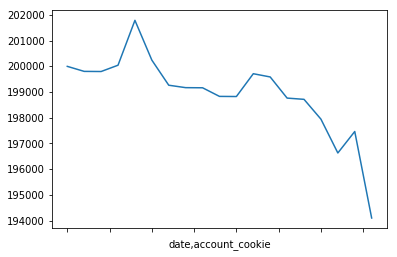

In [24]:
Risk.assets.plot()

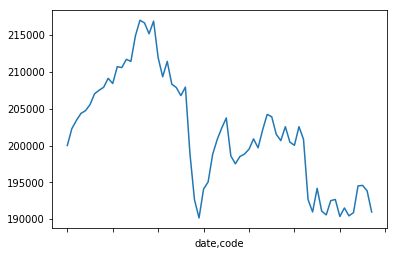

In [25]:
Risk.benchmark_assets.plot()

## STEP6: 存储结果

In [26]:
Account.save()
Risk.save()

## STEP7: 查看存储的结果

In [27]:
account_info=QA.QA_fetch_account({'account_cookie':'JCSC_EXAMPLE'})

In [28]:
account=QA.QA_Account().from_message(account_info[0])

In [29]:
account

< QA_Account JCSC_EXAMPLE>